In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is: {most_recent_date}")

The most recent date in the dataset is: 2017-08-23


Most recent date: 2017-08-23 00:00:00
Date one year ago: 2016-08-23 00:00:00


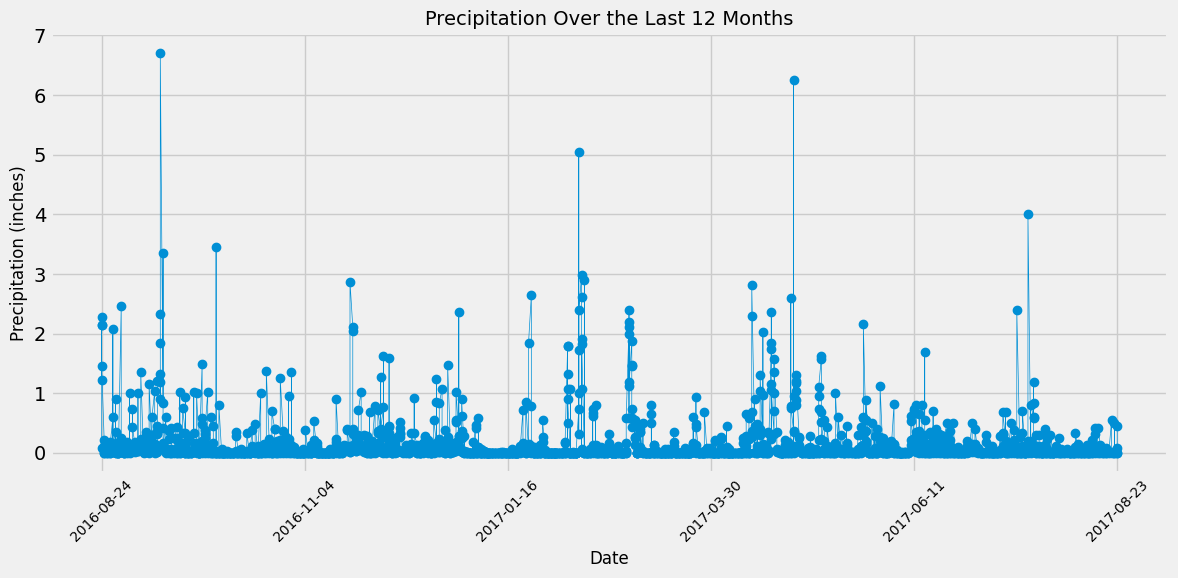

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. Calculate the date one year from the last date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')  # Convert to datetime
one_year_ago = most_recent_date - timedelta(days=365)

print(f"Most recent date: {most_recent_date}")
print(f"Date one year ago: {one_year_ago}")

# 2. Perform a query to retrieve the data and precipitation scores
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)

# 3. Save the query results as a Pandas DataFrame with explicit column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Drop rows with missing values
precipitation_df = precipitation_df.dropna()

# Convert 'date' column to datetime format for proper handling
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# 4. Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values('date')

# 5. Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 6))
plt.plot(precipitation_df['date'], precipitation_df['precipitation'], marker='o', linestyle='-', linewidth=0.5)

# Format x-ticks for readability (reduce to a subset)
plt.xticks(
    ticks=pd.date_range(start=precipitation_df['date'].min(), 
                        end=precipitation_df['date'].max(), 
                        periods=6),
    rotation=45,
    fontsize=10
)

# Labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Precipitation (inches)', fontsize=12)
plt.title('Precipitation Over the Last 12 Months', fontsize=14)
plt.tight_layout()
plt.show()


In [49]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df['precipitation'].describe()
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64


# Exploratory Station Analysis

In [50]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [51]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station).label('count'))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# Print the results
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [52]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperature_stats = (
    session.query(
        func.min(Measurement.tobs).label('Min Temperature'),
        func.max(Measurement.tobs).label('Max Temperature'),
        func.avg(Measurement.tobs).label('Avg Temperature')
    )
    .filter(Measurement.station == most_active_station)
    .one()
)

# Print the results
print(f"Temperature statistics for station {most_active_station}:")
print(f"Lowest Temperature: {temperature_stats[0]}°F")
print(f"Highest Temperature: {temperature_stats[1]}°F")
print(f"Average Temperature: {temperature_stats[2]:.1f}°F")

Temperature statistics for station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.7°F


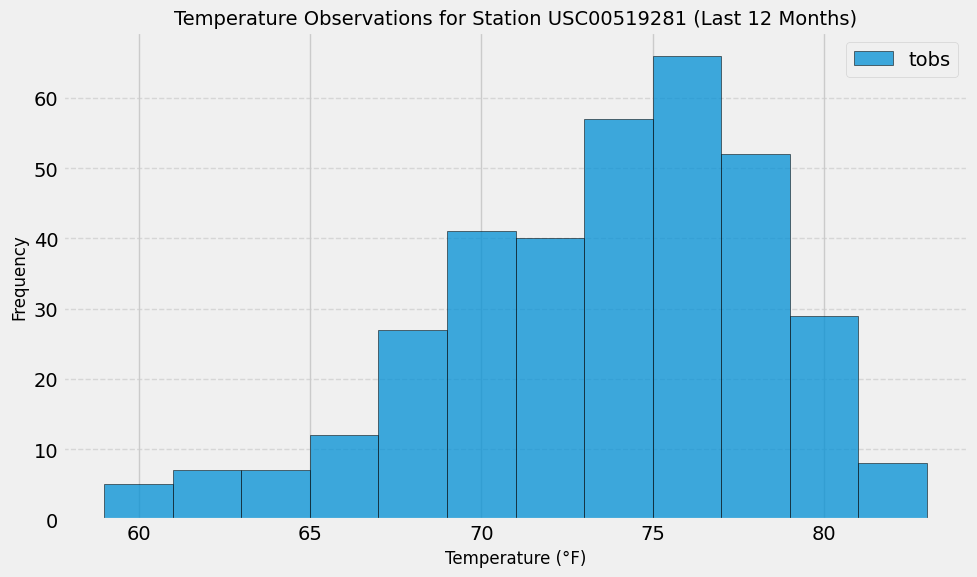

In [56]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = active_stations[0][0]

temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)
# Convert the query results into a flat list
temperature_list = [temp[0] for temp in temperature_data]

# Plot the results as a histogram with bins=12
plt.figure(figsize=(10, 6))
plt.hist(temperature_list, bins=12, alpha=0.75, edgecolor='black', label="tobs")
plt.title(f'Temperature Observations for Station {most_active_station} (Last 12 Months)', fontsize=14)
plt.xlabel('Temperature (°F)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right') 
plt.tight_layout()
plt.show()


# Close Session

In [57]:
# Close Session
session.close()